In [1]:
#Import Packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
import datetime as dt
sns.set_style('darkgrid')

import yfinance as yf

First, I will present a high-risk, but potentially high profit portfolio containing growth stocks, emerging market equities, crypto assets, and sector-specific ETFs. I will use volatility and $\beta$ to characterize the risks of the portfolio, where $\beta$ measures how much a stock (or portfolio) moves relative to the market.

In [23]:
#load data for high risk stocks: NVIDIA, Tesla, ARK innovation ETF, Coinbase, Bitcoin Futures ETF
tickers = ['NVDA', 'TSLA', 'ARKK', 'COIN', 'BITO']

start_date = dt.datetime.today()-dt.timedelta(days = 2*365)
end_date = dt.datetime.today()

stock = yf.download(tickers, start = start_date, end =end_date)



[*********************100%***********************]  5 of 5 completed


In [24]:
# Step 1: Compute cumulative return from 'Close' prices
close = stock['Close']
normalized_returns = (close/close.iloc[0]-1)*100 #Moves stock prices to a start of 0


# Step 2: Create MultiIndex columns for new data
normalized_returns.columns = pd.MultiIndex.from_product([['Cumulative Return'], normalized_returns.columns])

# Step 3: Concatenate to the original DataFrame
stock = pd.concat([stock, normalized_returns], axis =1 )

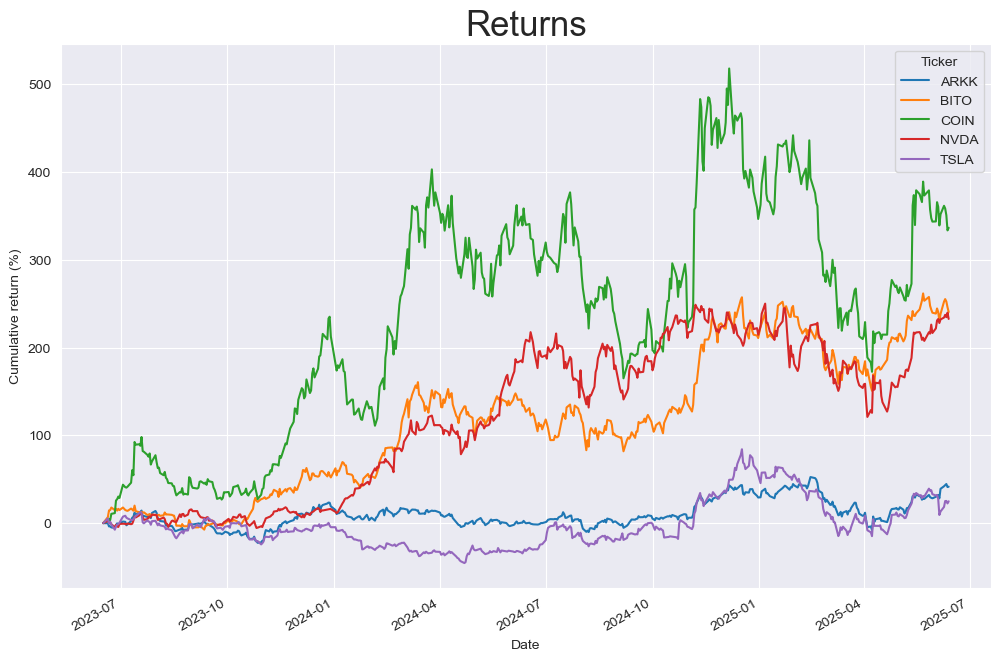

In [25]:
#Plot Cumlative Returns together
stock['Cumulative Return'].plot(figsize = (12,8))
plt.title(f'Returns', size = 25)
plt.ylabel('Cumulative return (%)')
plt.show()

In [26]:
#Create a dataframe of daily returns
#It is quite common to take the logs of daily returns to lessen computational complexity in standard deviation
daily_returns = np.log(stock['Close']/stock['Close'].shift(1))
daily_returns = daily_returns.dropna()

#Create a dictionary of standard deviations of daily return
#Normalize the standard deviation for yearly by multiplying by sqrt(#trading days in year ~ 252)
annualized_volatility = {ticker: np.std(daily_returns[ticker])*np.sqrt(252) for ticker in tickers}
covariance_matrix = 252*((daily_returns).cov())
annualized_volatility

{'NVDA': 0.5172018103556857,
 'TSLA': 0.6311201126324346,
 'ARKK': 0.4105938070168872,
 'COIN': 0.7961372405949098,
 'BITO': 0.5171480368324846}

We can see that the volatility of these stocks is relatively large.

In [28]:
# Calculate betas
stock_tickers = ['NVDA', 'TSLA', 'ARKK', 'COIN', 'BITO']
market_ticker = '^GSPC'

# Download data
data = yf.download(tickers + [market_ticker], period="2y")['Close']

# Calculate daily returns
returns = data.pct_change().dropna()

# Separate market returns
market_returns = returns[market_ticker]

# Calculate beta for each stock
betas = {}
for ticker in stock_tickers:
    covariance = returns[ticker].cov(market_returns)
    variance = market_returns.var()
    beta = covariance / variance
    betas[ticker] = beta

# Display results
for ticker, beta in betas.items():
    print(f"Beta for {ticker}: {beta:.2f}")

[*********************100%***********************]  6 of 6 completed

Beta for NVDA: 2.19
Beta for TSLA: 2.35
Beta for ARKK: 2.02
Beta for COIN: 2.46
Beta for BITO: 1.06


By definiton, $\beta=1$ for the market. $\beta>1$ means that a stock moves in correlation with the market, but the sizes of the movements are larger. Notice that even though the volatility is large for BITO, $\beta$ is still close to 1. BITO is a Bitcoin futures ETF and it seems that Bitcoin is weakly correlated with the market. Furthermore, BITO tracks Bitcoin futures reducing the correlation with both Bitcoin and the stock market.

In [29]:
#Find a set of weights, equivalently portfolio investment percentages in stock_symbols, 
#which minimizes a historical portfolio's volatility subject to the following investment constraints
#1) Must invest at least 10% of capital into each index
#2) Cannot invest more than 35% of capital into a single index

# Number of assets
n_assets = len(tickers)

# Define an initial guess for asset weights (e.g., equal weights)
initial_weights = np.array([1/n_assets] * n_assets)

# Define weight constraints
#Sum of weights equals 1 
#Allocate at least 3% of capital into each index in stock_symbols
#Do not allocate more than 35% of capital into each index in stock_symbol
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1},
               {'type': 'ineq', 'fun': lambda weights: min(weights)-.1},
              {'type': 'ineq', 'fun': lambda weights: .35-max(weights)})

# Define the objective function to minimize portfolio variance
def portfolio_volatility(weights):
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    return portfolio_std_dev

# Run the optimization to find the optimal weights
result = minimize(portfolio_volatility, initial_weights, constraints=constraints)

# Optimal asset weights
optimal_weights = result.x

# Print the optimal weights and expected returns
print("Optimal Asset Weights to minimize volatility:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: Weight = {weight:.4f}")

Optimal Asset Weights to minimize volatility:
NVDA: Weight = 0.3010
TSLA: Weight = 0.2351
ARKK: Weight = 0.1000
COIN: Weight = 0.2639
BITO: Weight = 0.1000


In [46]:
print(f' The optimal volatility subject to the constraints is {result.fun:.3f}')
print(f' The beta of the portfolio after minimizing volatility is {sum(optimal_weights*np.array(list(betas.values()))):.3f}')

 The optimal volatility subject to the constraints is 0.402
 The beta of the portfolio after minimizing volatility is 2.167


Now I will do the same for a low risk portfolio, where I expect a lower volatility and $\beta$.

In [47]:
#load data for low risk stocks: Vanguard Total Bond Market ETF, Vanguard Real Estate ETF, 
#Vanguard Total Stock Market ETF, Consumer Staples Select Sector ETF, SPDR Gold Shares
tickers = ['BND', 'VNQ', 'VTI', 'XLP', 'GLD']

start_date = dt.datetime.today()-dt.timedelta(days = 2*365)
end_date = dt.datetime.today()

stock = yf.download(tickers, start = start_date, end =end_date)

[*********************100%***********************]  5 of 5 completed


The reasons why these assets were chosen:

    - Diversified across asset classes (bonds, stocks, real estate, gold).

    - Low correlation among components → smoother ride.

    - Stable sectors like consumer staples add downside protection.

    - Gold and bonds act as hedges in turbulent markets.


In [48]:
# Step 1: Compute cumulative return from 'Close' prices
close = stock['Close']
normalized_returns = (close/close.iloc[0]-1)*100 #Moves stock prices to a start of 0


# Step 2: Create MultiIndex columns for new data
normalized_returns.columns = pd.MultiIndex.from_product([['Cumulative Return'], normalized_returns.columns])

# Step 3: Concatenate to the original DataFrame
stock = pd.concat([stock, normalized_returns], axis =1 )

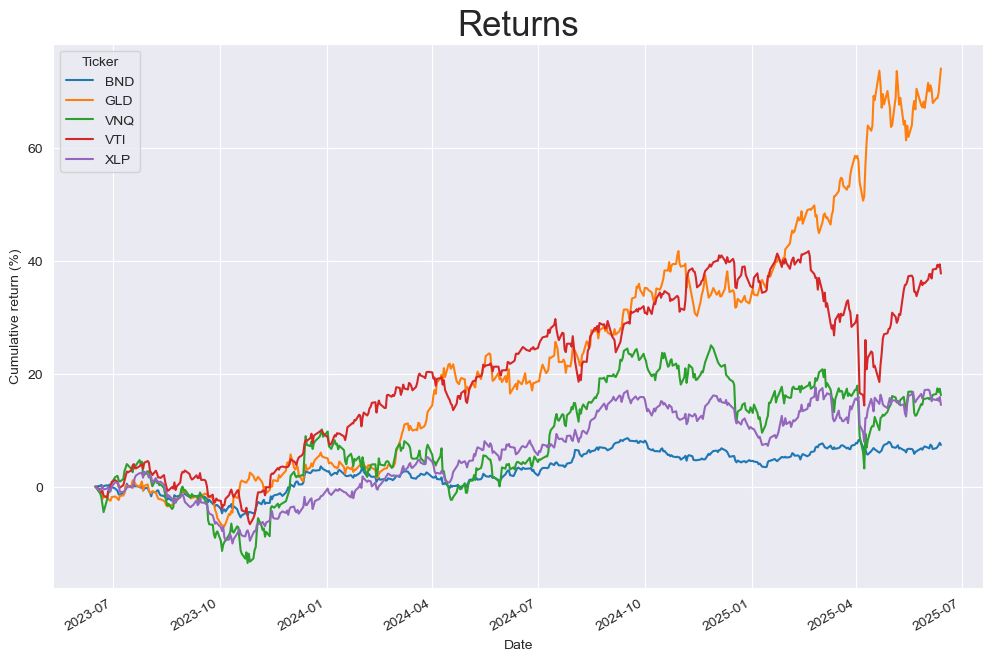

In [49]:
#Plot Cumlative Returns together
stock['Cumulative Return'].plot(figsize = (12,8))
plt.title(f'Returns', size = 25)
plt.ylabel('Cumulative return (%)')
plt.show()

In [50]:
#Create a dataframe of daily returns
#It is quite common to take the logs of daily returns to lessen computational complexity in standard deviation
daily_returns = np.log(stock['Close']/stock['Close'].shift(1))
daily_returns = daily_returns.dropna()

#Create a dictionary of standard deviations of daily return
#Normalize the standard deviation for yearly by multiplying by sqrt(#trading days in year ~ 252)
annualized_volatility = {ticker: np.std(daily_returns[ticker])*np.sqrt(252) for ticker in tickers}
covariance_matrix = 252*((daily_returns).cov())
annualized_volatility

{'BND': 0.0594730120810259,
 'VNQ': 0.18268648055635064,
 'VTI': 0.1655246217381099,
 'XLP': 0.12045617948976095,
 'GLD': 0.15605894347495414}

These assets have much lower volatility than the ones in the high-risk portfolio.

In [51]:
# Calculate betas
stock_tickers = ['BND', 'VNQ', 'VTI', 'XLP', 'GLD']
market_ticker = '^GSPC'

# Download data
data = yf.download(tickers + [market_ticker], period="2y")['Close']

# Calculate daily returns
returns = data.pct_change().dropna()

# Separate market returns
market_returns = returns[market_ticker]

# Calculate beta for each stock
betas = {}
for ticker in stock_tickers:
    covariance = returns[ticker].cov(market_returns)
    variance = market_returns.var()
    beta = covariance / variance
    betas[ticker] = beta

# Display results
for ticker, beta in betas.items():
    print(f"Beta for {ticker}: {beta:.2f}")

[*********************100%***********************]  6 of 6 completed

Beta for BND: 0.06
Beta for VNQ: 0.68
Beta for VTI: 1.03
Beta for XLP: 0.32
Beta for GLD: 0.12


The betas are all below 1 (except for VTI which is basically the market itself) indicating that these assets either have very weak correlation to the market or they have small volatility.

In [52]:
#Find a set of weights, equivalently portfolio investment percentages in stock_symbols, 
#which minimizes a historical portfolio's volatility subject to the following investment constraints
#1) Must invest at least 10% of capital into each index
#2) Cannot invest more than 35% of capital into a single index

# Number of assets
n_assets = len(tickers)

# Define an initial guess for asset weights (e.g., equal weights)
initial_weights = np.array([1/n_assets] * n_assets)

# Define weight constraints
#Sum of weights equals 1 
#Allocate at least 3% of capital into each index in stock_symbols
#Do not allocate more than 35% of capital into each index in stock_symbol
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1},
               {'type': 'ineq', 'fun': lambda weights: min(weights)-.1},
              {'type': 'ineq', 'fun': lambda weights: .35-max(weights)})

# Run the optimization to find the optimal weights
result = minimize(portfolio_volatility, initial_weights, constraints=constraints)

# Optimal asset weights
optimal_weights = result.x

# Print the optimal weights and expected returns
print("Optimal Asset Weights to minimize volatility:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: Weight = {weight:.4f}")

Optimal Asset Weights to minimize volatility:
BND: Weight = 0.3500
VNQ: Weight = 0.1876
VTI: Weight = 0.1000
XLP: Weight = 0.1002
GLD: Weight = 0.2622


In [53]:
print(f' The optimal volatility subject to the constraints is {result.fun:.3f}')
print(f' The beta of the portfolio after minimizing volatility is {sum(optimal_weights*np.array(list(betas.values()))):.3f}')

 The optimal volatility subject to the constraints is 0.079
 The beta of the portfolio after minimizing volatility is 0.316


The optimized volatility and beta are much smaller compared to the high-risk portfolio.